# Stock Trades by Members of the US House of Representatives

* **See the main project notebook for instructions to be sure you satisfy the rubric!**
* See Project 03 for information on the dataset.
* A few example prediction questions to pursue are listed below. However, don't limit yourself to them!
    - Can you predict the party affiliation of a representative from their stock trades?
    - Can you predict the geographic region that the representative comes from using their stock trades? E.g., west coast, east coast, south, etc.
    * Can you predict whether a particular trade is a BUY or SELL?

Be careful to justify what information you would know at the "time of prediction" and train your model using only those features.

# Summary of Findings


### Introduction
In this notebook, we predict the party affiliation of a representative from their stock trades. In order to do so, we collected data from [https://housestockwatcher.com/api](https://housestockwatcher.com/api) and combined it with [https://www.kaggle.com/datasets/unanimad/us-election-2020](https://www.kaggle.com/datasets/unanimad/us-election-2020) in order to find the party membership of the candidates.
Overall, we had the four columns 'transaction_date', 'amount', 'ticker' and 'type' at our disposition in order to **predict the party membership** of associated politician. Therefore we have a classification problem. Our target variable is therefore 'party' and we picked the mean accuracy as an evaluation metric as this is a good metric for classification problems. Our assumption for this to work is that democrats, on average, trade differently than republicans.

### Baseline Model
The baseline model will be a DecisionTreeClassifier trained on 4 One-Hot-encoded features. We used the year that we calculated out of the transaction_date and one-hot-encoded ticker, amount and type directly. On a test dataset being 20% the size of the total data and 100 iterations, the baseline model attains an average mean accuracy of 0.79. We think that this is quite okay as this score is not achievable by guessing only. Although there is room for improvement as we will show with our final mode. The ticker and type are nominal, amount and year are ordinal.

### Final Model
In order to improve the baseline model, we took various measures:
- Transform the 'amount' variable into an integer and standardize it based on the transaction type. We think that this is good as it further classifies transaction types which are done by various parties.
- Put the 'transaction_date' into One-Hot-encoded bins. Divide the 3 years into bins. This is good as we are now able to represent time frames, that had different events (covid, ukraine war, ...), in a more accurate way.
- Use the support vector classifier SVC. We tried out different models and picked the best performing one

After that we wanted to find out the best hyperparameters for the number of transaction_date bins and the parameter C for the SVC classifier. First we did a coarse search to get an idea of the hyperparameters. Afterwards we used a GridSearch to fine-tune them and came to the parameters C=3.6, n_bins=14

### Fairness Evaluation
- We want to compare the accuracy of the produced model on data before first of March 2020 (the beginning of the pandemic) with its accuracy on data during and after covid.
- It turns out that the predictions are more accurate before covid and that this difference is significant according to a permutation test with 10_000 iterations.
- Further, we realised that the dataset contains more transactions effected by republicans which leads the model to predict the label "REP" with higher probability. This leads to a lower recall for democrats than for republicans. We found out, that by adapting the class_weights parameter accordingly, we can compensate this fact.

# Code
import the libraries and using the StdScalerByGroup Jan Moritz Meyer developed as a part of lab9

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from fuzzywuzzy import fuzz
import fuzzywuzzy.process as fwp
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.kernel_approximation import Nystroem

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import KBinsDiscretizer
from stdscaler import StdScalerByGroup

from sklearn import metrics


import time, datetime

from sklearn.metrics import confusion_matrix

%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # Higher resolution figures

/Users/marc/opt/anaconda3/envs/stock-analysis/lib/python3.10/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
class StdScalerByGroup(BaseEstimator, TransformerMixin):

    def __init__(self):
        pass

    def fit(self, X, y=None):
        """
        :Example:
        >>> cols = {'g': ['A', 'A', 'B', 'B'], 'c1': [1, 2, 2, 2], 'c2': [3, 1, 2, 0]}
        >>> X = pd.DataFrame(cols)
        >>> std = StdScalerByGroup().fit(X)
        >>> std.grps_ is not None
        True
        """
        # X might not be a pandas DataFrame (e.g. a np.array)
        df = pd.DataFrame(X)

        # Compute and store the means/standard-deviations for each column (e.g. 'c1' and 'c2'),
        # for each group (e.g. 'A', 'B', 'C').
        # (Our solution uses a dictionary)
        self.groups = df[df.columns.tolist()[0]].unique().tolist()
        self.indizes = df.columns.tolist()[1:]
        self.grp_identifier = df.columns.tolist()[0]
        self.grps_ = df.groupby(self.grp_identifier).agg(["std", "mean"])
        return self

    def transform(self, X, y=None):
        """
        :Example:
        >>> cols = {'g': ['A', 'A', 'B', 'B'], 'c1': [1, 2, 3, 4], 'c2': [1, 2, 3, 4]}
        >>> X = pd.DataFrame(cols)
        >>> std = StdScalerByGroup().fit(X)
        >>> out = std.transform(X)
        >>> out.shape == (4, 2)
        True
        >>> np.isclose(out.abs(), 0.707107, atol=0.001).all().all()
        True
        """

        try:
            getattr(self, "grps_")
        except AttributeError:
            raise RuntimeError("You must fit the transformer before tranforming the data!")

        # Hint: Define a helper function here!

        df = pd.DataFrame(X)
        for group in self.groups:
            for index in self.indizes:
                df.loc[df[self.grp_identifier] == group, index] = (df.loc[df[self.grp_identifier] == group, index] -
                                                                   self.grps_[index, "mean"][group]) / \
                                                                  self.grps_[index, "std"][group]
        return df.drop(self.grp_identifier, axis=1).fillna(0.0)

the merge_parties method as we developed it in project03

In [3]:
def merge_parties(path_cand='./data/house_candidate.csv', path_trans='./data/all_transactions.csv'):
    data_candidates = pd.read_csv(path_cand)
    data_candidates["candidate"] = data_candidates["candidate"].str.lower()
    data_transactions = pd.read_csv(path_trans)
    data_transactions["representative"] = data_transactions["representative"]\
        .str.lower()\
        .str.replace("hon. ", "", regex=False)
    data_transactions["amount"] = data_transactions["amount"]\
        .str.replace("$", "", regex=False)\
        .str.replace(" ", "", regex=False)\
        .str.replace(",", "", regex=False)\
        .str.split("-")\
        .apply(lambda x : np.floor(pd.to_numeric(pd.Series(x), errors="coerce").mean()))
    data_transactions.loc[data_transactions["ticker"] == "--", "ticker"] = np.NaN
    choices = data_transactions["representative"].unique().tolist()
    data_candidates["representative"] = data_candidates["candidate"].apply(lambda x : fmatch(x, choices))
    data_candidates = data_candidates[["representative", "party"]].drop_duplicates().dropna()
    data_candidates = remove_duplicate_name(data_candidates)
    data_transactions = data_transactions[["transaction_date", "ticker", "type", "amount", "representative"]]\
        .drop_duplicates()
    return data_transactions.merge(data_candidates, how="left", left_on="representative", right_on="representative")

def fmatch(row, choices):
    choice = fwp.extractOne(row, choices, scorer=fuzz.token_set_ratio, score_cutoff=81)
    return np.NaN if choice is None else choice[0]

def count_names(search, list):
    return len(list[list["representative"] == search]) if not search == np.NaN else np.NaN

def remove_duplicate_name(df):
    new_df = df.copy()
    unique_names = pd.DataFrame(new_df["representative"]
                                .apply(lambda x : x if count_names(x, new_df) == 1 else np.NaN).dropna())
    return unique_names.merge(df, how="left", left_on="representative", right_on="representative", suffixes=("l", "r"))

In [4]:
data = merge_parties()
data.head()

,transaction_date,ticker,type,amount,representative,party
0,2021-09-27,BP,purchase,8000.0,virginia foxx,REP
1,2021-09-13,XOM,purchase,8000.0,virginia foxx,REP
2,2021-09-10,ILPT,purchase,32500.0,virginia foxx,REP
3,2021-09-28,PM,purchase,32500.0,virginia foxx,REP
4,2021-09-17,BLK,sale_partial,8000.0,alan s. lowenthal,DEM


In [21]:
stocks = merge_parties()
stocks = stocks.dropna()
stocks = stocks[stocks["transaction_date"].str[:5].apply(lambda x: x in ["2019-", "2020-", "2021-", "2022-"])]
stocks = stocks[stocks["party"].isin(["DEM","REP"])]

X = stocks[['type', 'amount', 'transaction_date', 'ticker']]
y = stocks[["party"]]

### Baseline Model
as described in the summary

In [6]:
stocks = merge_parties().dropna()

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

year_prefix_hotencode = Pipeline([
    ("get-year", FunctionTransformer(lambda x : pd.DataFrame(x["transaction_date"].str[:4]))),
    ("onehot", OneHotEncoder(handle_unknown='ignore')),
])

preproc = ColumnTransformer(
transformers=[
    ('amount', OneHotEncoder(handle_unknown='ignore'), ["amount", "type", "ticker"]),
    ('year', year_prefix_hotencode, ["transaction_date"])
]
)
pl = Pipeline([
    ('preproc', preproc),
    ('embedding', DecisionTreeClassifier()),
])

pl.fit(X_train, y_train["party"])
(pl.score(X_train, y_train["party"]), pl.score(X_test, y_test["party"]))

(0.9398631616852718, 0.8033849477853799)

<AxesSubplot: ylabel='Frequency'>

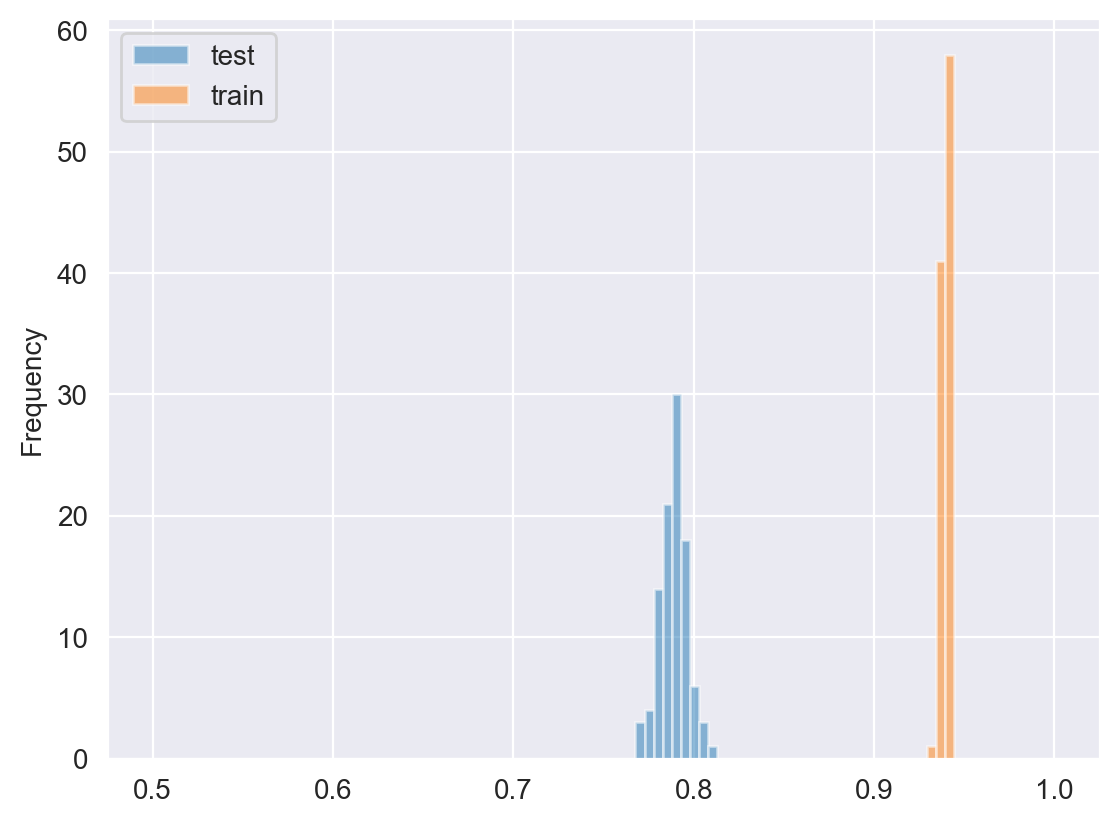

In [7]:
res = {"test":[],"train":[]}
for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(stocks[['type', 'amount', 'transaction_date', 'ticker']],
                                                        stocks[['party']],random_state=i)
    pl.fit(X_train, y_train["party"])
    res["test"].append(pl.score(X_test, y_test["party"]))
    res["train"].append(pl.score(X_train, y_train["party"]))

pd.DataFrame(res).plot.hist(bins=np.linspace(0.5, 1, 100),alpha=0.5)

## Final Model

- first optimizations by using better features and SVC (state vector machine) as a model

<AxesSubplot: >

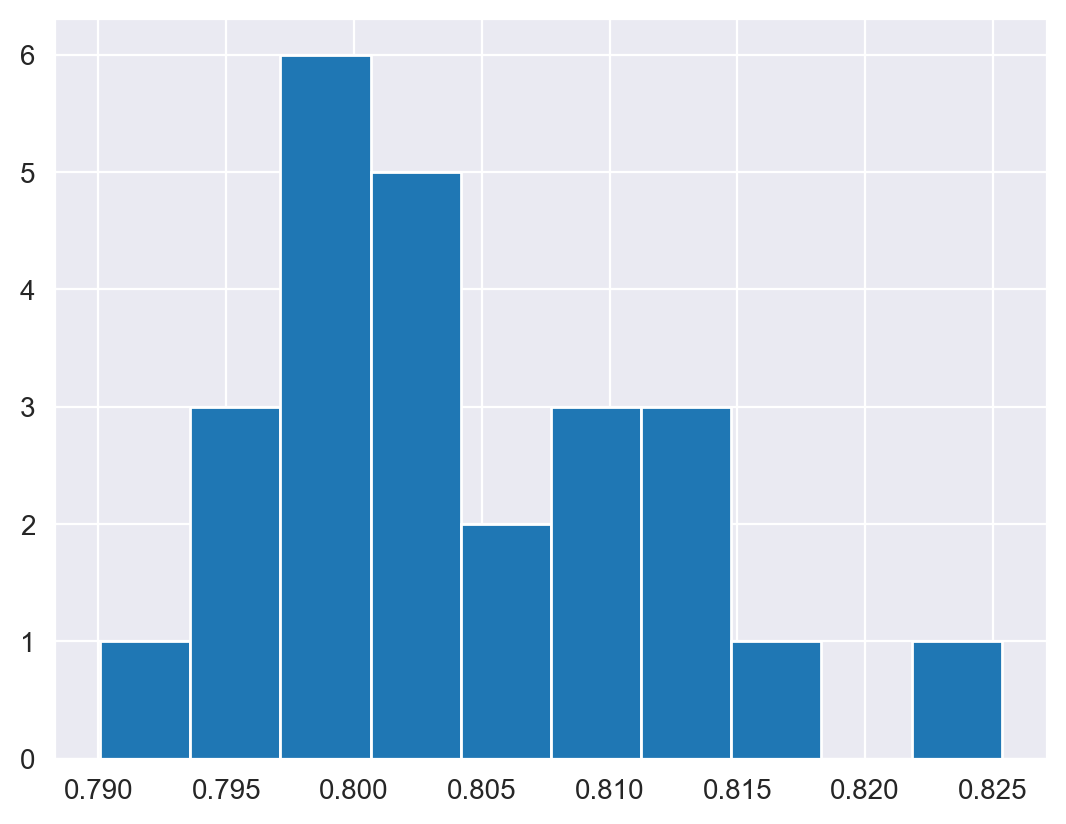

In [8]:
res = []
year_prefix_hotencode = Pipeline([
    ("transform-date-to-int", FunctionTransformer(lambda x : x["transaction_date"].apply(lambda x : time.mktime(datetime.datetime.strptime(x, "%Y-%m-%d").timetuple())))),
    ("to-2d-df", FunctionTransformer(lambda x : pd.DataFrame(x))),
    ("bins", KBinsDiscretizer()),
])
preproc = ColumnTransformer(
transformers=[
    ('amount', OneHotEncoder(handle_unknown='ignore'), ["amount", "type", "ticker"]),
    ('year', year_prefix_hotencode, ["transaction_date"]),
    ('stdscalerbygroup', StdScalerByGroup(), ["type", "amount"])
]
)
pl = Pipeline([
    ('preproc', preproc),
    ('embedding', SVC()),
])
for x in range(25):
    X_train, X_test, y_train, y_test = train_test_split(X, y.values.ravel(), random_state=x)
    pl.fit(X_train, y_train)
    res.append(pl.score(X_test, y_test))
pd.Series(res).hist()

## Coarse search for hyperparameter C

In [9]:
res = {"n":[],"test":[],"train":[]}
for n in np.arange(0.5,8,0.3):
    pl = Pipeline([
        ('preproc', preproc),
        ('embedding', SVC(C=n)),
    ])

    run = {"test":[],"train":[]}
    for i in range(5):
        X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=i)
        pl.fit(X_train, y_train["party"])
        run["test"].append(pl.score(X_test, y_test["party"]))
        run["train"].append(pl.score(X_train, y_train["party"]))

    mns = pd.DataFrame(run).mean()
    res["n"].append(n)
    res["test"].append(mns.loc["test"])
    res["train"].append(mns.loc["train"])

df = pd.DataFrame(res)
df.set_index("n").plot()

KeyboardInterrupt: 

our hyperparameter C seems good between 2 and 4

## coarse search for hyperparameter k_bins

In [ ]:
res = {}
for n in range(20, 180, 10):
    res[n] = []
    year_prefix_hotencode = Pipeline([
        ("transform-date-to-int", FunctionTransformer(lambda x : x["transaction_date"].apply(lambda x : time.mktime(datetime.datetime.strptime(x, "%Y-%m-%d").timetuple())))),
        ("to-2d-df", FunctionTransformer(lambda x : pd.DataFrame(x))),
        ("bins", KBinsDiscretizer(n_bins=n)),
    ])
    preproc = ColumnTransformer(
    transformers=[
        ('amount', OneHotEncoder(handle_unknown='ignore'), ["amount", "type", "ticker"]),
        ('year', year_prefix_hotencode, ["transaction_date"]),
        ('stdscalerbygroup', StdScalerByGroup(), ["type", "amount"])
    ]
    )
    pl = Pipeline([
        ('preproc', preproc),
        ('embedding', SVC(C=3)),
    ])
    for x in range(25):
        X_train, X_test, y_train, y_test = train_test_split(X, y.values.ravel(), random_state=x)
        pl.fit(X_train, y_train)
        res[n].append(pl.score(X_test, y_test))
pd.Series(res).apply(lambda x : np.mean(x)).plot()

/Users/jamo/opt/anaconda3/envs/dsc80/lib/python3.9/site-packages/sklearn/preprocessing/_discretization.py:291: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/Users/jamo/opt/anaconda3/envs/dsc80/lib/python3.9/site-packages/sklearn/preprocessing/_discretization.py:291: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/Users/jamo/opt/anaconda3/envs/dsc80/lib/python3.9/site-packages/sklearn/preprocessing/_discretization.py:291: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/Users/jamo/opt/anaconda3/envs/dsc80/lib/python3.9/site-packages/sklearn/preprocessing/_discretization.py:291: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
 

our hyperparameter for n_bins seems good between 10 and 16

## Gridsearch
With the information we got with the coarse search we did a GridSearch to find the best combination

In [ ]:
from sklearn.model_selection import GridSearchCV

year_prefix_hotencode = Pipeline([
    ("transform-date-to-int", FunctionTransformer(lambda x : x["transaction_date"].apply(lambda x : time.mktime(datetime.datetime.strptime(x, "%Y-%m-%d").timetuple())))),
    ("to-2d-df", FunctionTransformer(lambda x : pd.DataFrame(x))),
    ("bins", KBinsDiscretizer()),
])
preproc = ColumnTransformer(
transformers=[
    ('amount', OneHotEncoder(handle_unknown='ignore'), ["amount", "type", "ticker"]),
    ('year', year_prefix_hotencode, ["transaction_date"]),
    ('stdscalerbygroup', StdScalerByGroup(), ["type", "amount"])
]
)
pl = Pipeline([
    ('preproc', preproc),
    ('model', SVC()),
])


hyperparameters = {
    'preproc__year__bins__n_bins': range(6, 18, 1),
    'model__C': np.arange(2,4,0.1)
}
searcher = GridSearchCV(pl, hyperparameters, cv=5)
X_train, X_test, y_train, y_test = train_test_split(X, y.values.ravel(), random_state=42)
searcher.fit(X_train, y_train)
searcher.best_params_

## Final Model with hyperparameters

In [10]:
res = []
year_prefix_hotencode = Pipeline([
    ("transform-date-to-int", FunctionTransformer(lambda x : x["transaction_date"].apply(lambda x : time.mktime(datetime.datetime.strptime(x, "%Y-%m-%d").timetuple())))),
    ("to-2d-df", FunctionTransformer(lambda x : pd.DataFrame(x))),
    ("bins", KBinsDiscretizer(n_bins=14)),
])
preproc = ColumnTransformer(
transformers=[
    ('amount', OneHotEncoder(handle_unknown='ignore'), ["amount", "type", "ticker"]),
    ('year', year_prefix_hotencode, ["transaction_date"]),
    ('stdscalerbygroup', StdScalerByGroup(), ["type", "amount"])
]
)
pl = Pipeline([
    ('preproc', preproc),
    ('embedding', SVC(C=2.9)),
])


In [11]:
for x in range(25):
    X_train, X_test, y_train, y_test = train_test_split(X, y.values.ravel(), random_state=x)
    pl.fit(X_train, y_train)
    res.append(pl.score(X_test, y_test))
np.mean(res)

0.8334461649261793

1
2
3
4
5
6
7
8
9


<AxesSubplot: ylabel='Frequency'>

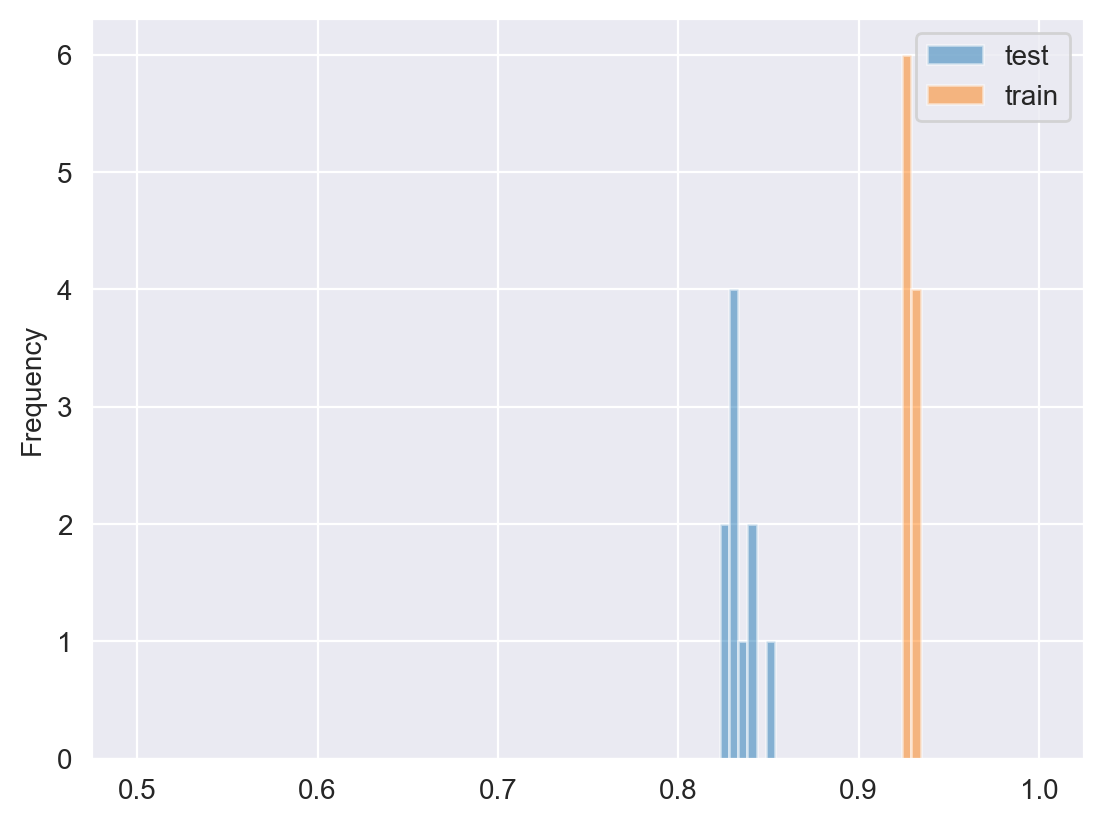

In [13]:
res = {"test":[],"train":[]}
for i in range(10):
    if i%10==0:
        print(i)
    pl = Pipeline([
        ('preproc', preproc),
        ('model', SVC(C=2.9)),
    ])
    X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=i)
    pl.fit(X_train, y_train["party"])
    res["test"].append(pl.score(X_test, y_test["party"]))
    res["train"].append(pl.score(X_train, y_train["party"]))
pd.DataFrame(res).plot.hist(bins=np.linspace(0.5, 1, 100),alpha=0.5)

### Fairness Evaluation

### Do permutation test to see if we predict traded after covid as well as trades before covid

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y.values.ravel(), random_state=42)

In [38]:
res = {}
res["year"] = X_test.transaction_date.apply(lambda x: x[:7])
res["pre_covid"] = X_test["transaction_date"].apply(lambda x : datetime.datetime.strptime(x, "%Y-%m-%d")<datetime.datetime.fromtimestamp(1583884800))
res["prediction"] = pl.predict(X_test)
res["tag"] = y_test

results = pd.DataFrame(res)
results

,year,pre_covid,prediction,tag
11255,2022-08,False,DEM,DEM
12760,2021-02,False,DEM,DEM
4045,2021-06,False,REP,REP
2740,2020-02,True,DEM,DEM
11906,2022-04,False,REP,REP
...,...,...,...,...
11691,2021-11,False,DEM,DEM
4950,2020-02,True,DEM,DEM
12936,2019-12,True,DEM,DEM
11510,2020-11,False,DEM,DEM


In [39]:
def accuracy(df):
    return (df["prediction"] == df["tag"]).mean()
results.groupby("pre_covid").apply(accuracy)

pre_covid
False    0.896287
True     0.940092
dtype: float64

Is this difference in accuracy before and after covid significant?
Let’s run a permutation test to see if it is.
- Null Hypothesis: The classifier’s accuracy is the same for democrats and republicans, and any differences are due to chance.
- Alternative Hypothesis: The classifier’s accuracy was higher before covid.
- Test statistic: Difference in accuracy (pre-covid minus post-covid).

Significance level: 0.01.

In [40]:
obs_acc = results.groupby('pre_covid').apply(accuracy)
obs = abs(obs_acc.loc[True]-obs_acc.loc[False])

In [41]:
diff_in_acc = []
for i in range(10_000):
    perm = results.copy().reset_index(drop=True)
    perm["pre_covid"] = results["pre_covid"].sample(frac=1.0, replace=False, random_state=i).reset_index(drop=True)
    acs = perm.groupby('pre_covid').apply(accuracy)
    diff_in_acc.append(abs(acs.loc[True]-acs.loc[False]))

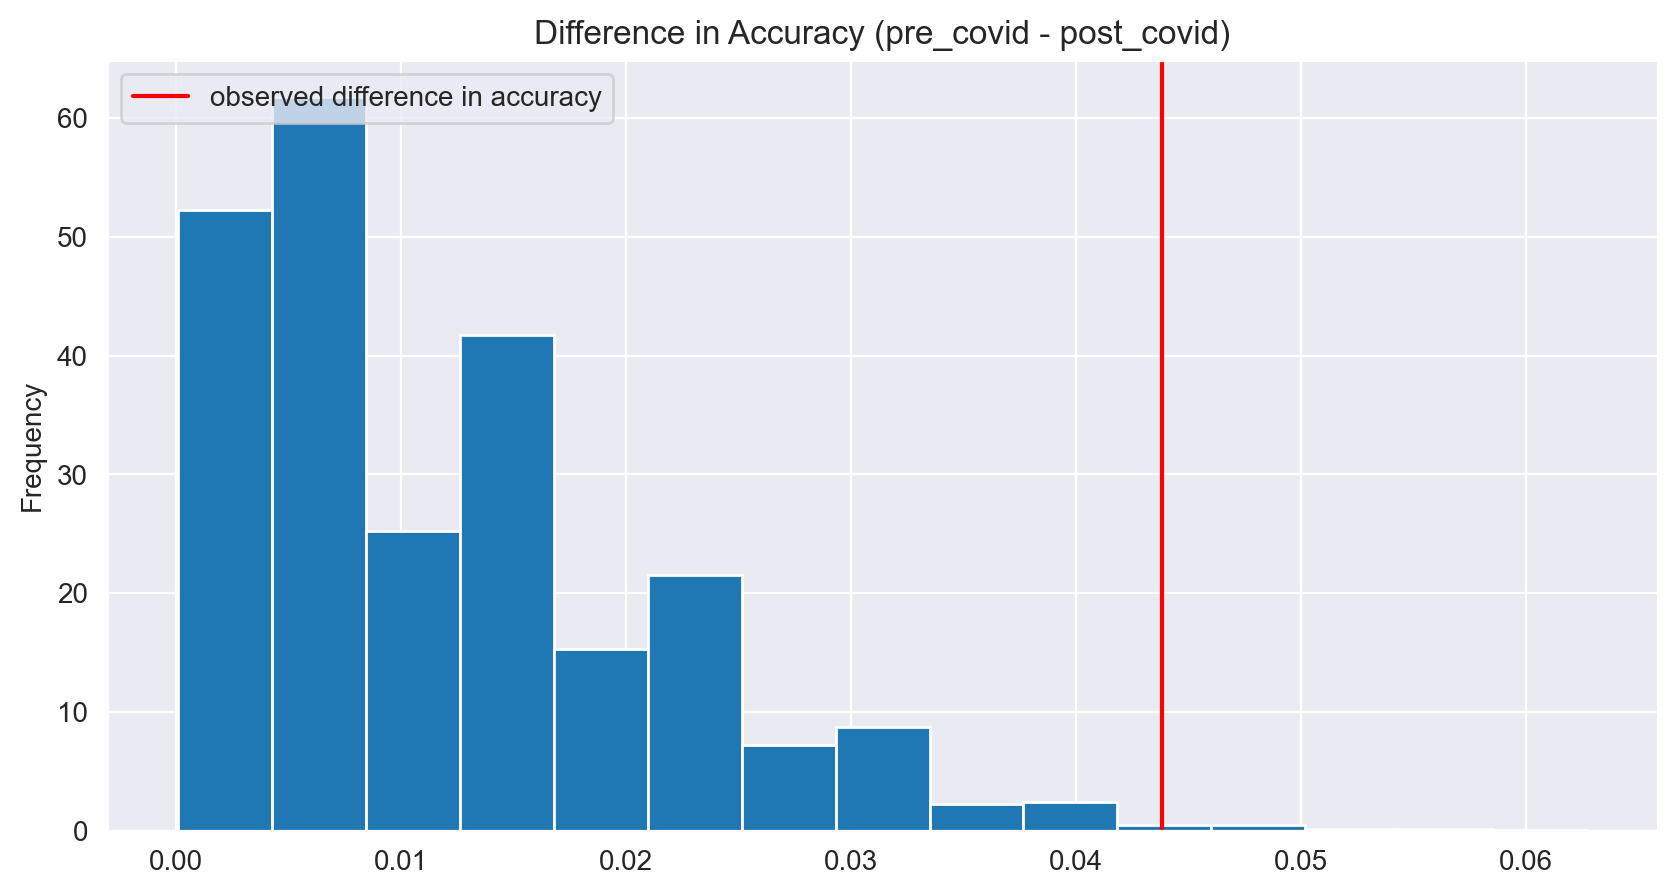

In [42]:
plt.figure(figsize=(10, 5))
pd.Series(diff_in_acc).plot(kind='hist', ec='w', density=True, bins=15, title='Difference in Accuracy (pre_covid - post_covid)')
plt.axvline(x=obs, color='red', label='observed difference in accuracy')
plt.legend(loc='upper left');

In [43]:
(diff_in_acc>obs).mean()

0.0033

As we can see, we can reject the null hypothesis. Therefore it is likely that we the accuracy of our model is higher on the pre-covid data than on the post-covid data. This is probably because the trading behaviour of humans changed during the crisis. The behaviour got less predictable and people act less rationally.

### Evaluate if we predict republicans as well as democrats in terms of recall

In [46]:
df = pd.DataFrame(confusion_matrix(
    stocks.drop(X_train.index)["party"],
    pl.predict(stocks.drop(X_train.index).drop("party", axis = 1))
))
df.columns = ["DEM_pred", "REP_pred"] #
df.index = ["DEM_ground", "REP_ground"] #

dem_recall = df["DEM_pred"]["DEM_ground"]/(df["DEM_pred"]["DEM_ground"]+df["REP_pred"]["DEM_ground"])
rep_recall = df["REP_pred"]["REP_ground"]/(df["REP_pred"]["REP_ground"]+df["DEM_pred"]["REP_ground"])

(dem_recall,rep_recall)

(0.9681425485961123, 0.772972972972973)

Democrats are more likely to get a correct label. This problem can be treated by adapting the 'class_weight' hyper parameter of the SVC. This comes with a loss in overall prediction accuracy tho. Let's find the perfect hyperparameter to obtain a fair model in terms of recall.

<AxesSubplot: xlabel='rep_weight'>

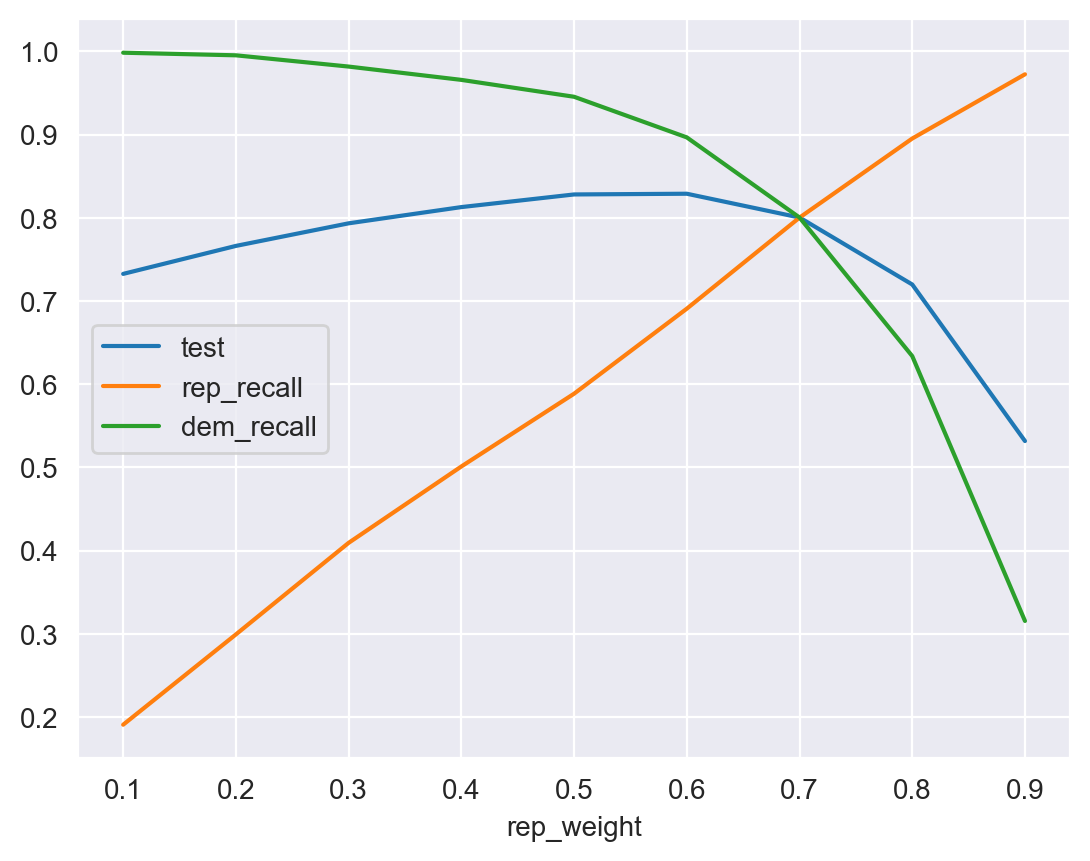

In [47]:
res = {
    "rep_weight":[],
    "test":[],
    "train":[],
    "rep_recall":[],
    "dem_recall":[]
}
for rep_weight in np.arange(0.1,1,0.1):
    pl = Pipeline([
        ('preproc', preproc),
        ('embedding', SVC(C=3,class_weight={"DEM":(1-rep_weight),"REP":rep_weight})),
    ])

    #print(rep_weight)

    run = {"test":[],"train":[],"rep_recall":[],"dem_recall":[]}
    for i in range(5):
        X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=i)
        pl.fit(X_train, y_train["party"])
        run["test"].append(pl.score(X_test, y_test["party"]))
        run["train"].append(pl.score(X_train, y_train["party"]))

        mtx = pd.DataFrame(confusion_matrix(stocks.drop(X_train.index)["party"],pl.predict(stocks.drop(X_train.index).drop("party", axis = 1))))
        if(len(mtx)==2):
            mtx.columns = ["DEM_pred", "REP_pred"] #
            mtx.index = ["DEM_ground", "REP_ground"] #
        else:
            mtx.columns = ["DEM_pred", "LIB_pred", "REP_pred"] #
            mtx.index = ["DEM_ground", "LIB_ground", "REP_ground"] #


        run["rep_recall"].append(mtx["REP_pred"]["REP_ground"]/(mtx["REP_pred"]["REP_ground"]+mtx["DEM_pred"]["REP_ground"]))
        run["dem_recall"].append(mtx["DEM_pred"]["DEM_ground"]/(mtx["DEM_pred"]["DEM_ground"]+mtx["REP_pred"]["DEM_ground"]))

    mns = pd.DataFrame(run).mean()
    res["rep_weight"].append(rep_weight)
    res["test"].append(mns.loc["test"])
    res["train"].append(mns.loc["train"])
    res["rep_recall"].append(mns.loc["rep_recall"])
    res["dem_recall"].append(mns.loc["dem_recall"])


df = pd.DataFrame(res)
df.set_index("rep_weight").drop("train",axis=1).plot()

In [50]:
res = []
year_prefix_hotencode = Pipeline([
    ("transform-date-to-int", FunctionTransformer(lambda x : x["transaction_date"].apply(lambda x : time.mktime(datetime.datetime.strptime(x, "%Y-%m-%d").timetuple())))),
    ("to-2d-df", FunctionTransformer(lambda x : pd.DataFrame(x))),
    ("bins", KBinsDiscretizer(n_bins=14)),
])
preproc = ColumnTransformer(
transformers=[
    ('amount', OneHotEncoder(handle_unknown='ignore'), ["amount", "type", "ticker"]),
    ('year', year_prefix_hotencode, ["transaction_date"]),
    ('stdscalerbygroup', StdScalerByGroup(), ["type", "amount"])
]
)
pl = Pipeline([
    ('preproc', preproc),
    ('embedding', SVC(C=2.9,class_weight={"DEM":(1-0.7),"REP":0.7})),
])
for x in range(25):
    X_train, X_test, y_train, y_test = train_test_split(X, y.values.ravel(), random_state=x)
    pl.fit(X_train, y_train)
    res.append(pl.score(X_test, y_test))
np.mean(res)

0.7927691753691035

In [52]:
df = pd.DataFrame(confusion_matrix(
    stocks.drop(X_test.index)["party"],
    pl.predict(stocks.drop(X_test.index).drop("party", axis = 1))
))
df.columns = ["DEM_pred", "REP_pred"] #
df.index = ["DEM_ground", "REP_ground"] #

dem_recall = df["DEM_pred"]["DEM_ground"]/(df["DEM_pred"]["DEM_ground"]+df["REP_pred"]["DEM_ground"])
rep_recall = df["REP_pred"]["REP_ground"]/(df["REP_pred"]["REP_ground"]+df["DEM_pred"]["REP_ground"])

(dem_recall,rep_recall)

(0.8714080459770115, 0.9018471568272365)

Therefore, the best rep_weight is attained at 0.7. At this point, the model has the same recall for republicans as for democrats. The downside is that we loose a litte on accuracy.